In [438]:
# KISS - Keep It Simple Stupid
# https://towardsdatascience.com/convolutional-neural-network-1368ee2998d3
# https://github.com/SkyThonk/real-and-fake-face-detection/blob/master/model.ipynb

# ogólne
import tensorflow as tf
import numpy as np

# ładowanie danych
from keras.preprocessing.image import ImageDataGenerator

# budowanie modelu
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.optimizers import Adam
from keras import Sequential, Model, Input

# proces uczenia
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

# wizualizacja
import matplotlib.pyplot as plt
from keras.utils import load_img
import pickle
import cv2

# klasyfikacja
from keras.models import load_model

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)  
tf.data.experimental.enable_debug_mode()

In [445]:
# Przygotowanie danych
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

path = r"C:\Users\User\Desktop\Matematyka stosowana - II stopień\III semestr\Uczenie ze wzmocnieniem i deeplearning\deep_learning\Zadanie 1"
nbatch = 64

datagen = ImageDataGenerator(validation_split=0.15,
                             rescale=1./255,
                             rotation_range=10.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             horizontal_flip=True)

train_data = datagen.flow_from_directory(directory=path+r"\train",
                                         target_size=(224,224),
                                         shuffle=True,
                                         color_mode="rgb",
                                         batch_size=nbatch,
                                         class_mode='binary',
                                         subset='training') # set as training data


valid_data = datagen.flow_from_directory(directory=path+r"\train",
                                         target_size=(224,224),
                                         shuffle=True,
                                         color_mode="rgb",
                                         batch_size=nbatch,
                                         class_mode='binary',
                                         subset='validation') # set as validation data

Found 1082 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


(64, 224, 224, 3) (64,)


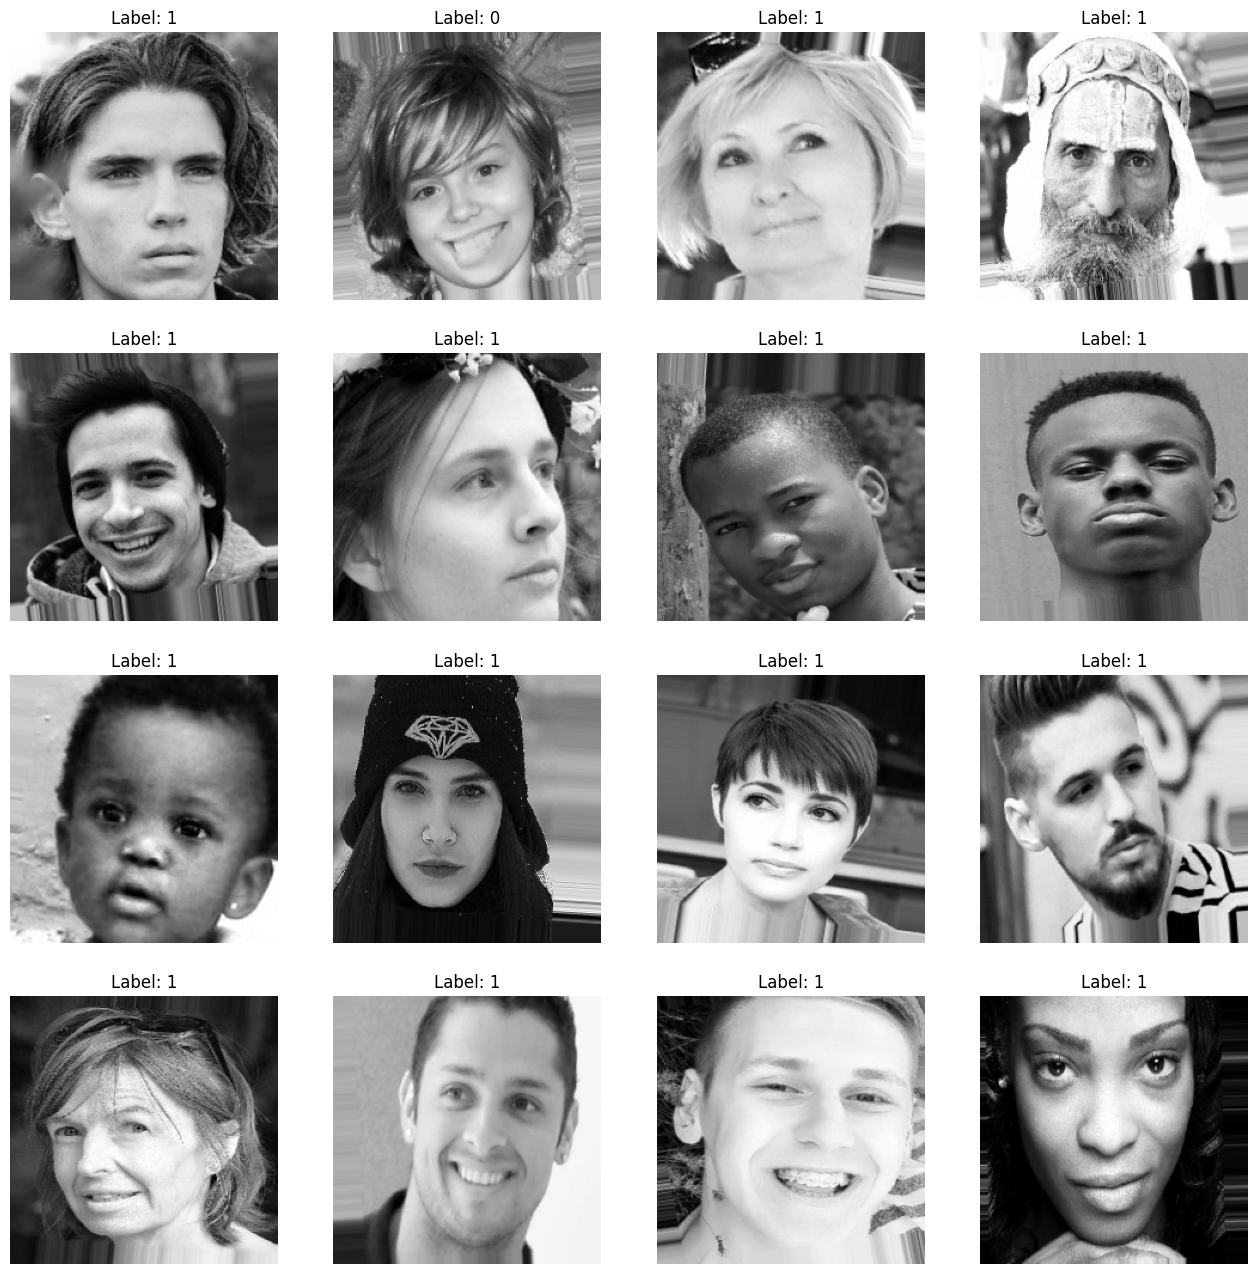

In [446]:
for X, y in train_data:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: {}'.format(int(y[i]))) # 1 - REAL; 0 - FAKE
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

In [282]:
unique_train = np.unique(train_data.classes, return_counts=True)
labels_dict_train = dict(zip(unique_train[0], unique_train[1]))
print(labels_dict_train)

unique_valid = np.unique(valid_data.classes, return_counts=True)
labels_dict_valid = dict(zip(unique_valid[0], unique_valid[1]))
print(labels_dict_valid)

{0: 192, 1: 890}
{0: 33, 1: 157}


In [283]:
def get_class_weight(data):
    n_samples = len(data)
    n_classes = len(np.unique(data))

    class_weight = dict()

    for classes in np.unique(data):
        score = n_samples/(n_classes*np.bincount(data)[classes])
        class_weight[classes] = score
        
    return class_weight

In [284]:
class_weights = get_class_weight(train_data.classes)
class_weights

{0: 2.8177083333333335, 1: 0.6078651685393258}

In [285]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(activation="relu", units=256))
model.add(Dense(activation="sigmoid", units=1))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 26, 26, 64)     

In [286]:
# porównanie optymalizatorów http://ruder.io/optimizing-gradient-descent/
model.compile(optimizer=Adam(lr=0.0001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

c:\Users\User\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [364]:
# Hipoteza - val_accuracy jest zgubne, bo zlosliwie albo daje 1 albo 2 i heja
# dodatkowo, po wykresie widac ze loss maleje, a val_acc oscyluje
# Uwaga, kazdorazowe trenowanie modelu, to wciaz jego trenowanie
metric = "val_loss" #"val_accuracy"

# String formatting rules - https://mkaz.blog/code/python-string-format-cookbook/
filepath=path+"\\KISS\\models\\"+metric+"\\weights-improvement-epoch{epoch:03d}-loss{val_loss:.2f}-acc{val_accuracy:.2f}.hdf5"

# steps = https://stackoverflow.com/questions/60509425/how-to-use-repeat-function-when-building-data-in-keras
steps = int(train_data.samples/nbatch)
epoch = 100
valid_steps = int(valid_data.samples/nbatch)

checkpoint = ModelCheckpoint(filepath,
                             monitor=metric,
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq="epoch")

early = EarlyStopping(monitor=metric,
                      min_delta=0,
                      patience=int(epoch/4),
                      verbose=1,
                      mode='auto')

hist = model.fit_generator(steps_per_epoch=steps,
                           generator=train_data,
                           validation_data=valid_data,
                           validation_steps=valid_steps,
                           epochs=epoch,
                           callbacks=[checkpoint,early],
                           class_weight=class_weights) 

C:\Users\User\AppData\Local\Temp\ipykernel_34408\1479021420.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=steps,


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.7868
Epoch 1: val_loss improved from inf to 0.96917, saving model to C:\Users\User\Desktop\Matematyka stosowana - II stopień\III semestr\Uczenie ze wzmocnieniem i deeplearning\deep_learning\Zadanie 1\KISS\models\val_loss\weights-improvement-epoch001-loss0.97-acc0.55.hdf5
16/16 [==============================] - 46s 3s/step - loss: 0.4151 - accuracy: 0.7868 - val_loss: 0.9692 - val_accuracy: 0.5547
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.7998
Epoch 2: val_loss improved from 0.96917 to 0.85197, saving model to C:\Users\User\Desktop\Matematyka stosowana - II stopień\III semestr\Uczenie ze wzmocnieniem i deeplearning\deep_learning\Zadanie 1\KISS\models\val_loss\weights-improvement-epoch002-loss0.85-acc0.61.hdf5
16/16 [==============================] - 45s 3s/step - loss: 0.3968 - accuracy: 0.7998 - val_loss: 0.8520 - val_accuracy: 0.6094
Epoch 3/100
16

In [365]:
# zapisanie historii nauki
name = "epochs_{}_steps_{}_{:%Y_%m_%d_%H_%M}".format(checkpoint.params['epochs'], checkpoint.params['steps'], datetime.now())
with open('trainHistoryDict/{}.pickle'.format(name), 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

# otwarcie historii nauki
with open('trainHistoryDict/{}.pickle'.format(name), "rb") as file_pi:
    history = pickle.load(file_pi)

In [366]:
len(history["accuracy"])

32

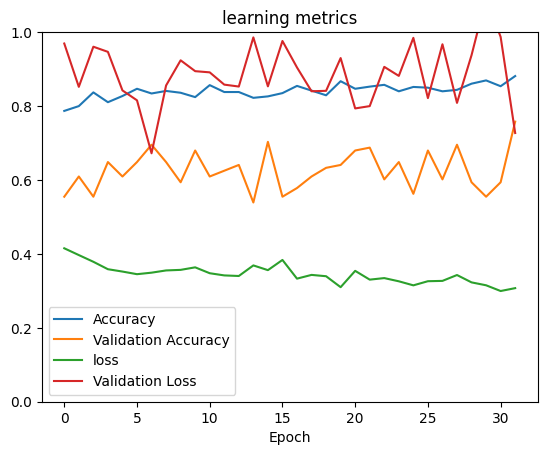

In [368]:
plt.plot(history["accuracy"])
plt.plot(history['val_accuracy'])
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0, 1) 
plt.title("learning metrics")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [455]:
# https://stackoverflow.com/questions/52270177/how-to-use-predict-generator-on-new-images-keras
# https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
datagen_test = ImageDataGenerator(rescale=1./255)

test_data = datagen_test.flow_from_directory(directory=path+r"\test",
                                             target_size=(224,224),
                                             shuffle=False,
                                             color_mode="rgb",
                                             class_mode='binary')

test_data.reset() # else weird outputs will come.

folder = "val_accuracy" #"val_accuracy", "val_loss"

# weights-improvement-epoch004-loss0.58-acc0.75.hdf5 - najlepszy model dla "val_accuracy" 14/25 ~56%
# weights-improvement-epoch009-loss0.62-acc0.64.hdf5 - najlepszy dla "val_loss" 13/25 ~52%
model = load_model("models/"+folder+"/weights-improvement-epoch004-loss0.58-acc0.75.hdf5")

pred=model.predict_generator(test_data, verbose=1)
predicted_class_indices=pred.round().flatten()

labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

Found 26 images belonging to 1 classes.


C:\Users\User\AppData\Local\Temp\ipykernel_34408\4089931087.py:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_data, verbose=1)


1/1 [==============================] - 0s 455ms/step


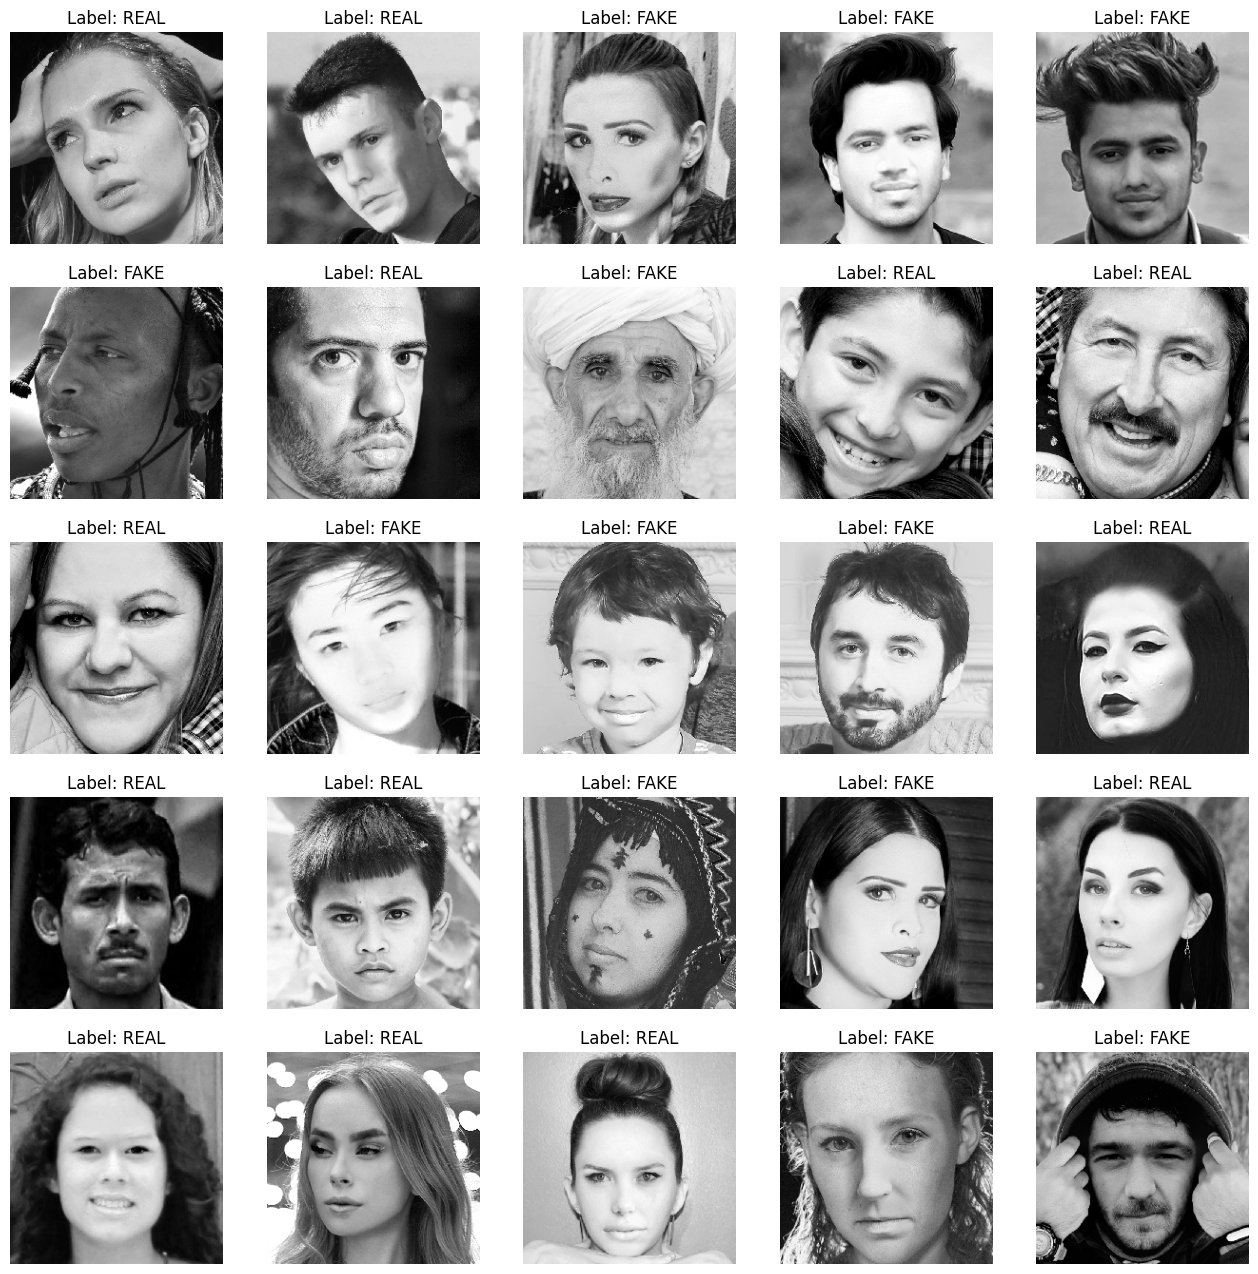

In [456]:
# WHOLE TEST SET PREDICTION 
for X, _ in test_data:
    plt.figure(figsize=(16,16))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.title('Label: {}'.format(predictions[i]))
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

REAL


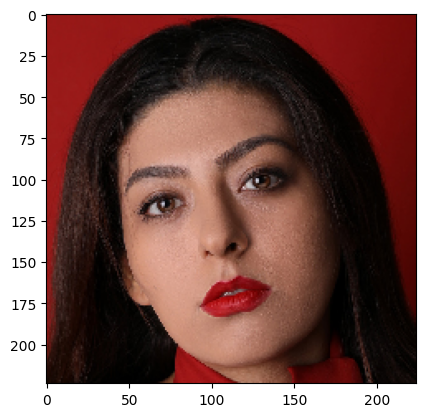

In [432]:
# SINGLE IMAGE PREDICTION
folder = "val_accuracy" #"val_accuracy", "val_loss"

img = load_img(path+r"\test\TS1\test_image_set1 (6).jpg", target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

saved_model = load_model("models/"+folder+"/weights-improvement-epoch024-loss0.58-acc0.74.hdf5")
output = saved_model.predict(img, verbose=0)

if output[0][0] == 1.:
    print("REAL")
else:
    print('FAKE')